In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from matplotlib import animation
from IPython.display import HTML

In [2]:
train_data = np.load("datasets/dy_trn_data.npy")
val_data = np.load("datasets/dy_val_data.npy")
test_data = np.load("datasets/dy_tst_data.npy")

In [3]:
def apply_preprocessing(data_full):
    pt = np.sqrt(data_full[...,1]**2 + data_full[...,2]**2)
    eta1 = np.arctanh(data_full[...,3] / np.sqrt(data_full[...,1]**2 + data_full[...,2]**2 + data_full[...,3]**2))
    eta2 = np.arctanh(data_full[...,7] / np.sqrt(data_full[...,5]**2 + data_full[...,6]**2 + data_full[...,7]**2))
    phi1 = np.arctanh(np.arctan2(data_full[...,2], data_full[...,1]) / np.pi)
    return np.stack((pt, eta1, eta2, phi1), axis=-1)
    
def invert_preprocessing(data_red):
    pt = data_red[...,0]
    eta1 = data_red[...,1]
    eta2 = data_red[...,2]
    phi1 = np.arctan(data_red[...,3]) * np.pi
    px1 = pt * np.cos(phi1)
    py1 = pt * np.sin(phi1)
    pz1 = pt * np.sinh(eta1)
    e1 = np.sqrt(px1**2 + py1**2 + pz1**2)
    px2 = -px1
    py2 = -py1
    pz2 = pt * np.sinh(eta2)
    e2 = np.sqrt(px2**2 + py2**2 + pz2**2)
    return np.stack((e1, px1, py1, pz1, e2, px2, py2, pz2), axis=-1)

def get_obs(event):
    jet1_4m = event[...,0:4]
    jet2_4m = event[...,4:]
    event_4m = jet1_4m + jet2_4m
    event_im = np.sqrt(event_4m[...,0]**2 - event_4m[...,1]**2 - event_4m[...,2]**2 - event_4m[...,3]**2)
    pt = np.sqrt(jet1_4m[...,1]**2 + jet1_4m[...,2]**2)
    return event_im, pt

In [4]:
train_data_preproc = apply_preprocessing(train_data)
train_mean = np.mean(train_data_preproc, axis=0)
train_std = np.std(train_data_preproc, axis=0)
train_data_normalized = torch.Tensor((train_data_preproc - train_mean) / train_std)
train_dataset = TensorDataset(train_data_normalized)
train_dataloader = DataLoader(train_data_normalized, batch_size=1024, shuffle=True)

In [5]:
class JetDiffusion(nn.Module):
    def __init__(
        self,
        data_dim: int,   # number of features in the data
        n_steps: int,    # number of time steps
        n_layers: int,   # number of network layers
        hidden_dim: int, # number of hidden layer nodes
    ):
        super().__init__()
        self.data_dim = data_dim
        self.n_steps = n_steps

        # Initialize alpha, beta and sigma constants for the given number of time steps
        self.betas = self.linear_beta_schedule(n_steps)
        alphas = 1 - self.betas
        alphas_bar = torch.cumprod(alphas, dim=0)
        alphas_bar_prev = F.pad(alphas_bar[:-1], (1, 0), value=1.)
        self.one_minus_alphas_bar = 1 - alphas_bar
        self.sqrt_alphas = torch.sqrt(alphas)
        self.sqrt_alphas_bar = torch.sqrt(alphas_bar)
        self.sqrt_one_minus_alphas_bar = torch.sqrt(self.one_minus_alphas_bar)
        self.sigmas = torch.sqrt(self.betas)

        # Build network
        layers = []
        layer_dim_in = data_dim + 1
        for i in range(n_layers - 1):
            layers.append(nn.Linear(layer_dim_in, hidden_dim))
            layers.append(nn.ReLU())
            layer_dim_in = hidden_dim
        layers.append(nn.Linear(layer_dim_in, data_dim))
        self.net = nn.Sequential(*layers)

    def linear_beta_schedule(
        self,
        n_steps: int   # number of time steps
    ) -> torch.Tensor: # beta values at the time steps, shape (n_steps, )
        scale = 1000 / n_steps
        beta_start = scale * 0.0001
        beta_end = scale * 0.02
        return torch.linspace(beta_start, beta_end, n_steps, dtype=torch.float64)

    def compute_xt(
        self,
        x0: torch.Tensor,    # data point x_0, shape (n_batch, data_dim)
        t: torch.Tensor,     # time step, shape (n_batch, 1)
        noise: torch.Tensor, # gaussian noise, shape (n_batch, data_dim)
    ) -> torch.Tensor:       # noisy point x_t, shape (n_batch, data_dim)
        return self.sqrt_alphas_bar[t] * x0 + self.sqrt_one_minus_alphas_bar[t] * noise

    def compute_relative_factor(
        self,
        t: torch.Tensor, # time step, shape (n_batch, 1)
    ) -> torch.Tensor:   # prefactor inside the MSE loss, shape (n_batch, 1)
        return self.betas[t] / (np.sqrt(2) * self.sigmas[t] * self.sqrt_alphas[t] * self.sqrt_one_minus_alphas_bar[t])

    def compute_mu_tilde_t(
        self,
        xt: torch.Tensor,    # noisy point x_t, shape (n_batch, data_dim)
        t: torch.Tensor,     # time step, shape (n_batch, 1)
        noise: torch.Tensor, # gaussian noise, shape (n_batch, data_dim)
    ) -> torch.Tensor:       # computes mu_tilde_t, shape (n_batch, data_dim)
        return (xt - noise * self.betas[t] / self.sqrt_one_minus_alphas_bar[t]) / self.sqrt_alphas[t]

    def batch_loss(
        self,
        x: torch.Tensor, # input data, shape (n_batch, data_dim)
    ) -> torch.Tensor:   # loss, shape (n_batch, )
        t = torch.randint(low=1, high=self.n_steps, size=(x.shape[0], 1))
        noise = torch.randn_like(x)
        xt = self.compute_xt(x, t, noise)
        c = self.compute_relative_factor(t)
        model_pred = self.net(torch.cat((xt.float(), t.float()), dim=1))
        return F.mse_loss(c * model_pred, c * noise)

    def sample(
        self,
        n_samples: int,        # number of samples
        keep_xt: bool = False, # whether to keep the intermediate x_t
    ) -> torch.Tensor:         # sampled data, shape (n_samples, data_dim) or (n_steps, n_samples, data_dim)
        x = torch.randn(n_samples, self.data_dim)
        if keep_xt:
            xts = torch.zeros((n_samples, self.n_steps + 1, self.data_dim))
            xts[:, self.n_steps] = x
        for t in reversed(range(self.n_steps)):
            z = torch.randn(n_samples, self.data_dim) if t > 0 else 0.
            model_pred = self.net(torch.cat((x, torch.full((x.shape[0], 1), t, dtype=torch.float32)), dim=1))
            x = self.compute_mu_tilde_t(x, t, model_pred) + self.sigmas[t] * z
            if keep_xt:
                xts[:, t] = x
        return xts if keep_xt else x

In [6]:
jet_diffusion = JetDiffusion(
    data_dim = 4,
    n_steps = 100,
    n_layers = 3,
    hidden_dim = 64,
)
optimizer = torch.optim.Adam(jet_diffusion.parameters(), lr=3e-4) # https://twitter.com/karpathy/status/801621764144971776

for epoch in range(50):
    epoch_losses = []
    for batch, x in enumerate(train_dataloader):
        loss = jet_diffusion.batch_loss(x)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
    print(f"Epoch {epoch+1}: loss = {np.mean(epoch_losses)}")

Epoch 1: loss = 0.0343061880857352
Epoch 2: loss = 0.02581944453772765
Epoch 3: loss = 0.024963980508683217
Epoch 4: loss = 0.024697494871946897
Epoch 5: loss = 0.024568465034610867
Epoch 6: loss = 0.024341912936355202
Epoch 7: loss = 0.02431794546729946
Epoch 8: loss = 0.024204749736158177
Epoch 9: loss = 0.02415984289045671
Epoch 10: loss = 0.02415285878248093
Epoch 11: loss = 0.024160728802341505
Epoch 12: loss = 0.024034619216763736
Epoch 13: loss = 0.02400142253185059
Epoch 14: loss = 0.024132315790294834
Epoch 15: loss = 0.023992254457215405
Epoch 16: loss = 0.02396328084498729
Epoch 17: loss = 0.023959455532730652
Epoch 18: loss = 0.024061107425015438
Epoch 19: loss = 0.023982615338020485
Epoch 20: loss = 0.02405112702685056
Epoch 21: loss = 0.023824391343786992
Epoch 22: loss = 0.02393906454842588
Epoch 23: loss = 0.023924190056836013
Epoch 24: loss = 0.023983010595337823
Epoch 25: loss = 0.0239419472578562
Epoch 26: loss = 0.023898648910165136
Epoch 27: loss = 0.02383234083312

In [7]:
with torch.no_grad():
    sample = jet_diffusion.sample(10000).cpu().numpy()
sample_pp = invert_preprocessing(sample * train_std + train_mean)
gen_event_im, gen_pt = get_obs(sample_pp)
test_event_im, test_pt = get_obs(test_data)

(array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.81311362e-05,
        1.48502639e-04, 2.28452316e-03, 6.52979920e-03, 9.62676994e-03,
        1.27971286e-02, 1.60236075e-02, 2.12160195e-02, 2.36326410e-02,
        1.58725147e-02, 1.25303419e-02, 1.07301791e-02, 9.37552420e-03,
        8.28765603e-03, 7.33188613e-03, 6.72406137e-03, 6.18358084e-03,
        5.58611673e-03, 5.18636835e-03, 4.77798609e-03, 4.55350535e-03,
        4.16670778e-03, 3.87488283e-03, 3.62536386e-03, 3.35685036e-03,
        3.18330949e-03, 3.00631506e-03, 2.87508017e-03, 2.68686171e-03,
        2.54526617e-03, 2.35014061e-03, 2.28797671e-03, 2.13429375e-03,
        2.04622823e-03, 1.90463269e-03, 1.83210815e-03, 1.74231585e-03,
        1.68619567e-03, 1.53164932e-03, 1.45998816e-03, 1.35379150e-03,
        1.28644728e-03, 1.22946371e-03, 1.17852385e-03, 1.16384627e-03,
        1.07491736e-03]),
 array([  0.        ,   4.08163265,   8.16326531,  12.24489796,
         16.32653061,  20.40816327,  24.489795

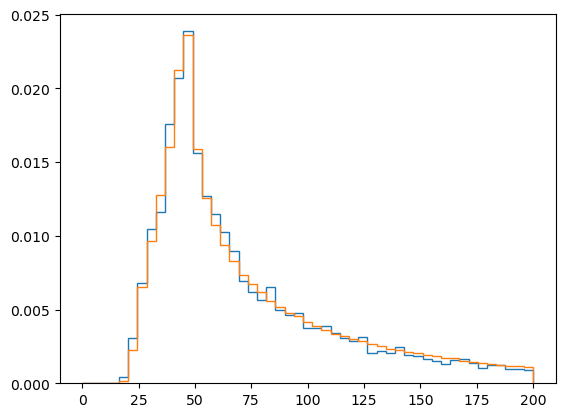

In [8]:
plt.hist(sample_pp[:,0], bins=np.linspace(0,200,50), density=True, histtype="step")
plt.hist(test_data[:,0], bins=np.linspace(0,200,50), density=True, histtype="step")

In [9]:
with torch.no_grad():
    sample_xt = jet_diffusion.sample(100000, keep_xt=True).cpu().numpy()
sample_pp = invert_preprocessing(sample_xt * train_std + train_mean)
gen_event_im, gen_pt = get_obs(sample_pp)
test_event_im, test_pt = get_obs(test_data)

In [10]:
test_observable = test_event_im #test_data[:, 0]
gen_observable = gen_event_im #sample_pp[:, :, 0]

bins = np.linspace(0,200,50)
test_hist, _ = np.histogram(test_observable, bins=bins, density=True)

fig, ax = plt.subplots()
ax.stairs(test_hist, edges=bins)
gen_stairs = ax.stairs(test_hist, edges=bins)

def draw_frame(t):
    gen_hist, _ = np.histogram(gen_observable[:, -1 - t], bins=bins, density=True)
    gen_stairs.set_data(values=gen_hist, edges=bins)
    return (gen_stairs, )

anim = animation.FuncAnimation(fig, draw_frame, frames=sample_pp.shape[1], interval=20, blit=True)
plt.close()
HTML(anim.to_jshtml())